In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import time
%matplotlib inline
import trap_util as tu
from trap_util import trap
from trap_util import quarter_trap
from trap_util import half_trap
# physical parameters
q = -1.60217662e-19 # coulombs
m = 9.10938356e-31 #kg (electron)
#m = 6.6359437706294e-26 #(calcium)
kB = 1.38064852e-23 # J/K
f = 1.5e9 # Electrode frequency, in Hertz

## Reading E-field data

In [4]:
# loading E field (vector)
data_RF = np.loadtxt("etrap_65V_1p5GHz_realsmoothExEy_500nm_25passes_quarter.fld", skiprows = 2)

In [5]:
data_DC = np.loadtxt("etrap_extraction_40_-40_-200V_smoothExEy_1micron_half.fld", skiprows = 2)

In [6]:
# manipulating E field data
df_DC = pd.DataFrame(data_DC, columns=['x', 'y', 'z', 'Ex', 'Ey', 'Ez'])
x_max_DC, x_min_DC = df_DC.x.max(), df_DC.x.min()
y_max_DC, y_min_DC = df_DC.y.max(), df_DC.y.min()
# print(x_max, x_min, y_max, y_min)
# print(df.y.nunique())
Nx_DC, Ny_DC = df_DC.x.nunique() - 1, df_DC.y.nunique() - 1 # numbers of intervals that divide each dimension
dx_DC, dy_DC = (x_max_DC-x_min_DC)/Nx_DC, (y_max_DC-y_min_DC)/Ny_DC # interval size
print("x_max = ", x_max_DC*1.0e3, "mm")
print("y_max = ", y_max_DC*1.0e3, "mm")
print("x_min = ", x_min_DC*1.0e3, "mm")
print("y_min = ", y_min_DC*1.0e3, "mm")
print("spatial resolution x: ", dx_DC*1.0e6, "um")
print("spatial resolution y: ", dy_DC*1.0e6, "um")

x_max =  2.0 mm
y_max =  2.0 mm
x_min =  0.0 mm
y_min =  -2.0 mm
spatial resolution x:  1.0 um
spatial resolution y:  1.0 um


In [7]:
# manipulating E field data
df_RF = pd.DataFrame(data_RF, columns=['x', 'y', 'z', 'Ex', 'Ey', 'Ez'])
x_max_RF, x_min_RF = df_RF.x.max(), df_RF.x.min()
y_max_RF, y_min_RF = df_RF.y.max(), df_RF.y.min()
# print(x_max, x_min, y_max, y_min)
# print(df.y.nunique())
Nx_RF, Ny_RF = df_RF.x.nunique() - 1, df_RF.y.nunique() - 1 # numbers of intervals that divide each dimension
dx_RF, dy_RF = (x_max_RF-x_min_RF)/Nx_RF, (y_max_RF-y_min_RF)/Ny_RF # interval size
print("x_max = ", x_max_RF*1.0e3, "mm")
print("y_max = ", y_max_RF*1.0e3, "mm")
print("x_min = ", x_min_RF*1.0e3, "mm")
print("y_min = ", y_min_RF*1.0e3, "mm")
print("spatial resolution x: ", dx_RF*1.0e6, "um")
print("spatial resolution y: ", dy_RF*1.0e6, "um")

x_max =  2.0000000000000004 mm
y_max =  2.0000000000000004 mm
x_min =  0.0 mm
y_min =  0.0 mm
spatial resolution x:  0.5000000000000001 um
spatial resolution y:  0.5000000000000001 um


## Initializing DC and RF Trap Objects

In [8]:
trap_RF = quarter_trap(df_RF, x_max_RF, x_min_RF, y_max_RF, y_min_RF,\
                      Nx_RF, Ny_RF, dx_RF, dy_RF, f=f)
trap_DC = half_trap(df_DC, x_max_DC, x_min_DC, y_max_DC, y_min_DC,\
                      Nx_DC, Ny_DC, dx_DC, dy_DC, f=0.0)

In [9]:
def E_field_sim(state, time):
    # this is a function that takes in a 2-element array state and a number time.
    # state[0] is current position and state[1] is current velocity.
    # it calculates the derivative of state, and returns a 2-element array,
    # with the 0th element being derivative of position and the 1th being 
    # the acceleration
    g0 = state[1]
    x, y = state[0]
    g1 = trap_DC.acceleration(x, y, time) #+ trap_RF.acceleration(x, y, time)
    return np.array([g0, g1])

def extracted(rou, phi, v, theta, dt, t_max):
    electron_pos=np.array([rou*np.cos(phi), rou*np.sin(phi)])
    electron_vel = np.array([v*np.cos(theta), v*np.sin(theta)])
    state = np.array([electron_pos, electron_vel])
    t = 0.0 # the time variable
    extracted = False
    
    # actual simulation
    while t < t_max:
        x, y = state[0]
        if trap_DC.hit_electrodes(x, y):
            break
        if y > trap_DC.y_max:
            extracted = True
            break
        if not trap_DC.within_boundary(x, y):
            break
        state = trap_DC.rk4(state, t, dt, E_field_sim)
        t += dt
    return extracted

Simulating T =  300.0 kelvin
The result for T =  300.0 kelvin:


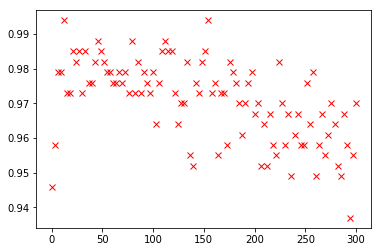

In [10]:
dt = 1.0e-11 #s
t_max = 5.0e-8 # maximum time duration of the simulation

#initial condition
rou_s = np.linspace(0, 300.0e-6, 100)
N_phi = 9
N_theta = 37

# A dictionary, taking temperature as key and the value is a 
# list of success rates correspond to each rou in rou_s
success_rate = dict() 
errors = dict()
for T in [300.0]:
    v = np.sqrt(kB*T/m)
    success_rate[T] = [] 
    errors[T] = []
    print("Simulating T = ", T, "kelvin")
    for rou in rou_s:
        result = []
        for phi in np.linspace(0, np.pi/2, N_phi):
            for theta in np.linspace(0, np.pi*2, N_theta):
                if extracted(rou, phi, v, theta, dt, t_max):
                    result.append(1)
                else:
                    result.append(0)
        success_rate[T].append(np.mean(result))
        errors[T].append(np.std(result)/np.sqrt(N_phi*N_theta))
    print("The result for T = ", T, "kelvin:")
    plt.figure()
    plt.plot(rou_s*1.0e6, success_rate[T], 'rx')
    